In [2]:
import sys
if '/home/ross/immunova' not in sys.path:
    sys.path.append('/home/ross/immunova')
from immunova.data.fcs_experiments import FCSExperiment
from immunova.flow.gating.actions import Gating
from immunova.flow.gating.transforms import apply_transform
from immunova.flow.gating.defaults import ChildPopulationCollection
from immunova.flow.gating.utilities import centroid, multi_centroid_calculation
from immunova.flow.plotting.static_plots import Plot
from immunova.data.mongo_setup import test_init
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from sklearn.neighbors import KDTree
from sklearn.cluster import DBSCAN, KMeans
from multiprocessing import Pool, cpu_count
from functools import partial
from itertools import cycle
from datetime import datetime
from matplotlib.patches import Rectangle, Ellipse
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import pandas as pd
import numpy as np
import functools
import warnings
import os
warnings.filterwarnings('ignore')
test_init()

In [3]:
if os.path.isfile('algo_times.csv'):
    performance = pd.read_csv('algo_times.csv').to_dict('list')
else:
    performance = dict(sample_id=[], task=[], method=[], time_seconds=[])

In [4]:
def timed_apply(sample_go, task_name, gate_name, performance_record, plot=True, save=True):
    start = datetime.now()
    sample_go.apply(gate_name, plot_output=plot)
    end = datetime.now()
    performance['sample_id'].append(sample_go.id)
    performance['method'].append(gate_name)
    performance['time_seconds'].append((end-start).total_seconds())
    performance['task'].append(task_name)
    if save:
        pd.DataFrame(performance).to_csv('algo_times.csv', index=False)
    return performance_record

In [5]:
exp = FCSExperiment.objects(experiment_id='ILTIS_T1').get()

In [6]:
samples = exp.list_samples()
samples = [x for x in samples if x!= 'sep6']

In [35]:
populations_to_remove = ['manual_gdt', 'manual_nongdt', 'manual_vd2Neg', 'manual_gdtNEG', 
                         'manual_nongdtNEG', 'manual_vd2NegNEG']
gates_to_remove = ['']
for x in samples:
    hc = Gating(exp, x)
    for p in populations_to_remove:
        if p in hc.populations.keys():
            hc.populations.pop(p)
    for g in gates_to_remove:
        if g in hc.gates.keys():
            hc.gates.pop(g)
    hc.save(overwrite=True)

Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!


In [ ]:
for x in samples:
    print(f'Gating {x}...')
    hc = Gating(exp, x)
    
    print('mixture model...')
    child_populations = ChildPopulationCollection('geom')
    child_populations.add_population('gmm_gdt', definition='+')
    child_populations.add_population('gmm_gdtNEG', definition='-')
    pre_filter=dict(xmin=0.4, xmax=1.0, ymin=0.4, ymax=1.0)
    gate_definition = dict(x='PanGD', y='Vd2', target=[0.6, 0.8], conf=0.99, rect_filter=pre_filter,
                      k=2)
    hc.create_gate(gate_name='gmm_gdt', parent='manual_liveCD3', class_='MixtureModel', method='gate',
                   kwargs=gate_definition, child_populations=child_populations)
    performance = timed_apply(sample_go=hc, task_name='Gamma Delta T cells', gate_name='gmm_gdt',
                          performance_record=performance, save=True, plot=False)
    
    child_populations = ChildPopulationCollection('geom')
    child_populations.add_population('gmm_nongdt', definition='+')
    child_populations.add_population('gmm_nongdtNEG', definition='-')
    pre_filter=dict(xmin=0, xmax=0.5, ymin=0, ymax=0.4)
    gate_definition = dict(x='PanGD', y='Vd2', target=[0.6, 0.8], conf=0.99, rect_filter=pre_filter,
                      k=2)
    hc.create_gate(gate_name='gmm_nongdt', parent='manual_liveCD3', class_='MixtureModel', method='gate',
                   kwargs=gate_definition, child_populations=child_populations)
    performance = timed_apply(sample_go=hc, task_name='Gamma Delta T cells', gate_name='gmm_nongdt',
                          performance_record=performance, save=True, plot=False)
    
    child_populations = ChildPopulationCollection('geom')
    child_populations.add_population('gmm_vd2Neg', definition='+')
    child_populations.add_population('gmm_vd2NegNEG', definition='-')
    pre_filter=dict(xmin=0.5, xmax=1, ymin=0, ymax=0.4)
    gate_definition = dict(x='PanGD', y='Vd2', target=[0.6, 0.8], conf=0.99, rect_filter=pre_filter,
                      k=2)
    hc.create_gate(gate_name='gmm_vd2Neg', parent='manual_liveCD3', class_='MixtureModel', method='gate',
                   kwargs=gate_definition, child_populations=child_populations)
    performance = timed_apply(sample_go=hc, task_name='Gamma Delta T cells', gate_name='gmm_vd2Neg',
                          performance_record=performance, save=True, plot=False)
    
    print('dbscan...')
    child_populations = ChildPopulationCollection('cluster')
    child_populations.add_population('dbscan_gdt', target=[0.6, 0.8], weight=2)
    child_populations.add_population('dbscan_nongdt', target=[0.2, 0.2], weight=2)
    child_populations.add_population('dbscan_vd2', target=[0.6, 0.2], weight=1)

    sampling_kwargs = dict()
    gate_definition = dict(x='PanGD', y='Vd2', min_pop_size=100, distance_nn=0.02,
                          downsample_method='density', frac=0.2)
    hc.create_gate(gate_name='dbscan_gdt', parent='manual_liveCD3', class_='DensityBasedClustering', 
                   method='dbscan', kwargs=gate_definition, child_populations=child_populations)
    performance = timed_apply(sample_go=hc, task_name='Gamma Delta T cells', gate_name='dbscan_gdt',
                          performance_record=performance, save=True, plot=False)
    
    print('hdbscan...')
    child_populations = ChildPopulationCollection('cluster')
    child_populations.add_population('hdbscan_gdt', target=[0.6, 0.8], weight=2)
    child_populations.add_population('hdbscan_nongdt', target=[0.2, 0.2], weight=2)
    child_populations.add_population('hdbscan_vd2', target=[0.6, 0.2], weight=1)

    gate_definition = dict(x='PanGD', y='Vd2', min_pop_size=100, downsample_method='density', frac=0.2)
    hc.create_gate(gate_name='hdbscan_gdt', parent='manual_liveCD3', class_='DensityBasedClustering', 
                   method='hdbscan', kwargs=gate_definition, child_populations=child_populations)
    performance = timed_apply(sample_go=hc, task_name='Gamma Delta T cells', gate_name='hdbscan_gdt',
                              performance_record=performance, save=True, plot=False)
    
    print('2D density threshold...')
    child_populations = ChildPopulationCollection('threshold_2d')
    child_populations.add_population('dens2d_gdt', definition=['++'])
    child_populations.add_population('dens2d_nongdt', definition=['--'])
    child_populations.add_population('dens2d_vd2', definition=['-+'])
    child_populations.add_population('dens2d_noise', definition=['+-'])
    gate_definition = dict(x='PanGD', y='Vd2', kde_bw=0.1, peak_threshold=0.05)
    hc.create_gate(gate_name='dens2d_gdt', parent='manual_liveCD3', class_='DensityThreshold', 
                     method='gate_2d', kwargs=gate_definition, child_populations=child_populations)
    performance = timed_apply(sample_go=hc, task_name='Gamma Delta T cells', gate_name='dens2d_gdt',
                          performance_record=performance, save=True, plot=False)
    hc.save(overwrite=True)
    print('Complete!')
    print('.........................................................')

Gating hc1...
pre-dbscan filter...
dbscan...
Expected 3 populations but found 2
Populations f['dbscan_nongdt', 'dbscan_vd2'] assigned to the same cluster 0;prioritising dbscan_nongdt based on weighting.
Population dbscan_vd2 has no associated gate, skipping...
Saved successfully!
Complete!
.........................................................
Gating hc4...
pre-dbscan filter...
dbscan...
Saved successfully!
Complete!
.........................................................
Gating hc5...
pre-dbscan filter...
dbscan...
Expected 3 populations but found 2
Populations f['dbscan_gdt', 'dbscan_vd2'] assigned to the same cluster 1;prioritising dbscan_gdt based on weighting.
Population dbscan_vd2 has no associated gate, skipping...
Saved successfully!
Complete!
.........................................................
Gating hc7...
pre-dbscan filter...
dbscan...
Expected 3 populations but found 2
Populations f['dbscan_gdt', 'dbscan_vd2'] assigned to the same cluster 1;prioritising dbscan_gd

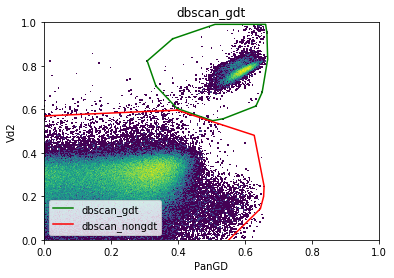

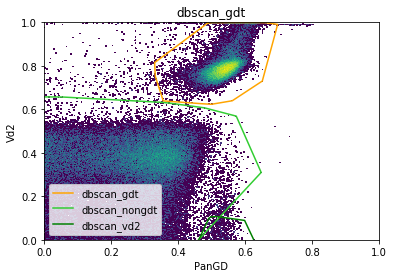

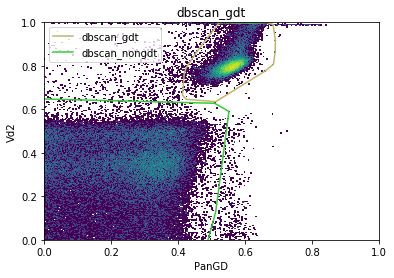

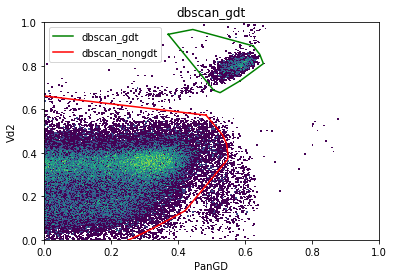

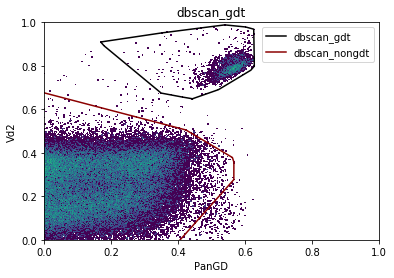

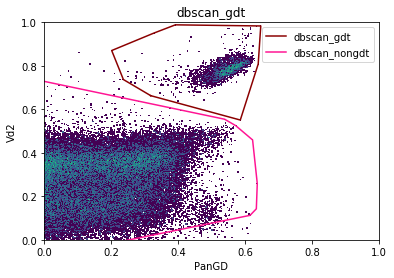

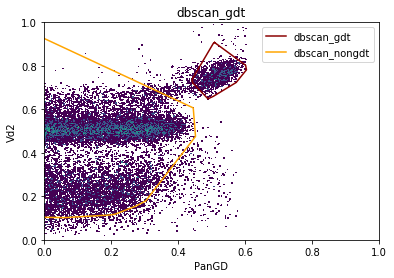

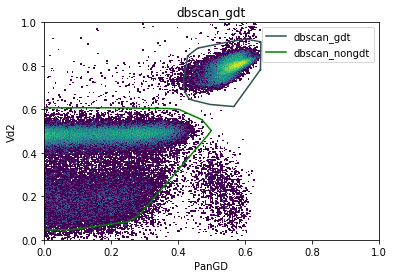

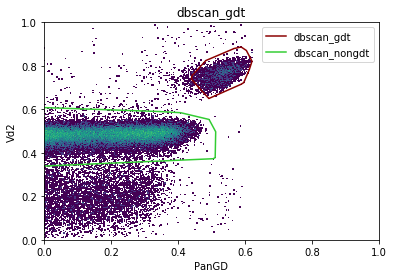

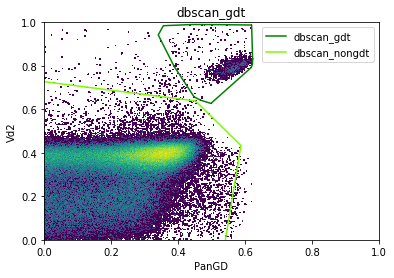

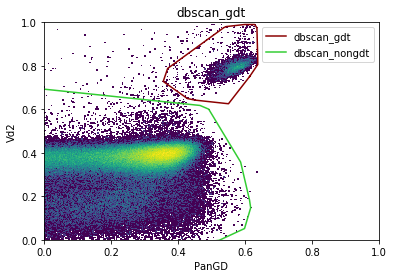

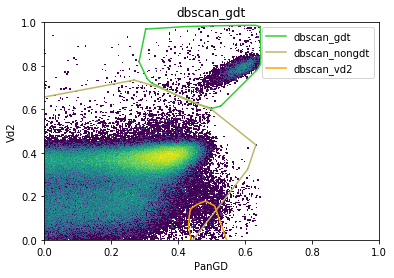

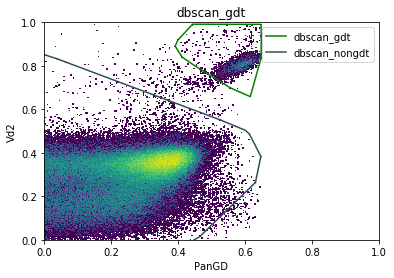

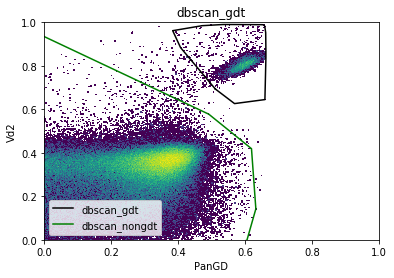

In [23]:
for x in samples:
    print(f'Gating {x}...')
    hc = Gating(exp, x)
    print('pre-dbscan filter...')
    # Debris Gate
    child_populations = ChildPopulationCollection('geom')
    child_populations.add_population('dbscan_cells', definition='+')
    child_populations.add_population('dbscan_debris', definition='-')
    gate_definition = dict(x='PanGD', y='Vd2', bottom_cutoff = 0.001, top_cutoff = 0.9999)
    hc.create_gate(gate_name='dbscan_debris_gate', parent='manual_liveCD3', class_='Static', method='border_gate',
                    kwargs=gate_definition, child_populations=child_populations)
    hc.apply('dbscan_debris_gate', plot_output=False)
    
    print('dbscan...')
    child_populations = ChildPopulationCollection('cluster')
    child_populations.add_population('dbscan_gdt', target=[0.6, 0.8], weight=2)
    child_populations.add_population('dbscan_nongdt', target=[0.2, 0.2], weight=2)
    child_populations.add_population('dbscan_vd2', target=[0.6, 0.2], weight=1)
    gate_definition = dict(x='PanGD', y='Vd2', min_pop_size=100, distance_nn=0.03,
                          downsample_method='density', frac=0.2)
    hc.create_gate(gate_name='dbscan_gdt', parent='dbscan_cells', class_='DensityBasedClustering', 
                   method='dbscan', kwargs=gate_definition, child_populations=child_populations)
    performance = timed_apply(sample_go=hc, task_name='Gamma Delta T cells', gate_name='dbscan_gdt',
                          performance_record=performance, save=True)
    hc.save(overwrite=True)
    print('Complete!')
    print('.........................................................')

In [8]:
hc = Gating(exp, 'hc1')
hc.populations.keys()

dict_keys(['root', 'cells', 'debris', 'lymphocytes', 'other_cells', 'manual_liveCD3', 'manual_liveCD3_Neg', 'gmm_liveCD3', 'gmm_liveCD3_NEG', 'dbscan_liveCD3', 'hdbscan_liveCD3', 'dens2d_liveCD3', 'dens2d_liveCD3_Neg', 'manual_gdt', 'manual_gdtNEG', 'manual_vd2Neg', 'manual_vd2NegNEG', 'manual_nongdt', 'manual_nongdtNEG', 'gmm_gdt', 'gmm_gdtNEG', 'gmm_nongdt', 'gmm_nongdtNEG', 'gmm_vd2Neg', 'gmm_vd2NegNEG', 'hdbscan_gdt', 'hdbscan_nongdt', 'hdbscan_vd2', 'dens2d_gdt', 'dens2d_nongdt', 'dens2d_vd2', 'dens2d_noise', 'dbscan_cells', 'dbscan_debris', 'dbscan_gdt', 'dbscan_nongdt', 'dbscan_vd2'])

In [39]:
gating_performance = dict(sample_id=[], population=[], method=[], accuracy=[], f1_score=[],
                         precision=[], recall=[], fpr=[])

def check_performance(hc, manual_pop, auto_pop, method):
    # Apply function and measure time taken
    gating_performance['sample_id'].append(hc.id)
    gating_performance['population'].append(manual_pop.split('_')[1])
    gating_performance['method'].append(method)
    
    #Pull data
    parent = hc.get_population_df(hc.gates[method].parent)
    manual_pop_idx = hc.populations[manual_pop].index
    auto_pop_idx = hc.populations[auto_pop].index
    parent['manual'], parent['auto'] = 0, 0
    parent['manual'] = parent['manual'].mask(parent.index.isin(manual_pop_idx), 1)
    parent['auto'] = parent['auto'].mask(parent.index.isin(auto_pop_idx), 1)
    
    # Rate performance of result
    recall = recall_score(y_true=parent['manual'].values, y_pred=parent['auto'])
    precision = precision_score(y_true=parent['manual'].values, y_pred=parent['auto'])
    accuracy = accuracy_score(y_true=parent['manual'].values, y_pred=parent['auto'])
    f1 = f1_score(y_true=parent['manual'].values, y_pred=parent['auto'])
    gating_performance['f1_score'].append(f1)
    gating_performance['accuracy'].append(accuracy)
    gating_performance['precision'].append(precision)
    gating_performance['recall'].append(recall)
    tn, fp, fn, tp = confusion_matrix(y_pred=parent['auto'], y_true=parent['manual']).ravel()
    gating_performance['fpr'].append(fp/(fp+tn))

In [40]:
for x in samples:
    hc = Gating(exp, x)
    print(f'Performance analysis for {x}...')
    manual_pops = ['manual_gdt', 'manual_vd2Neg', 'manual_nongdt']
    for m, a in zip(manual_pops, ['gmm_gdt', 'gmm_vd2Neg', 'gmm_nongdt']):
        check_performance(hc, m, a, 'gmm_gdt')
    for m, a in zip(manual_pops, ['hdbscan_gdt', 'hdbscan_vd2', 'hdbscan_nongdt']):
        check_performance(hc, m, a, 'hdbscan_gdt')
    for m, a in zip(manual_pops, ['dbscan_gdt', 'dbscan_vd2', 'dbscan_nongdt']):
        check_performance(hc, m, a, 'dbscan_gdt')
    for m, a in zip(manual_pops, ['dens2d_gdt', 'dens2d_vd2', 'dens2d_nongdt']):
        check_performance(hc, m, a, 'dens2d_gdt')


Performance analysis for hc1...
Performance analysis for hc4...
Performance analysis for hc5...
Performance analysis for hc7...
Performance analysis for hc9...
Performance analysis for hc10...
Performance analysis for hc11...
Performance analysis for hc12...
Performance analysis for hc13...
Performance analysis for hc15...
Performance analysis for hc16...
Performance analysis for hc17...
Performance analysis for hc18...
Performance analysis for hc19...


In [41]:
results = pd.DataFrame(gating_performance)

In [42]:
def rename_method(x):
    if x.split('_')[0] == 'gmm':
        return 'Gaussian Mixture Model'
    if x.split('_')[0] == 'dbscan':
        return 'DBSCAN'
    if x.split('_')[0] == 'hdbscan':
        return 'HDBSCAN'
    if x.split('_')[0] == 'dens2d':
        return 'Density threshold (2D)'
    return x
results['method'] = results['method'].apply(rename_method)

In [43]:
results

,sample_id,population,method,accuracy,f1_score,precision,recall,fpr
0,hc1,gdt,Gaussian Mixture Model,0.997660,0.970925,1.000000,0.943492,0.000000
1,hc1,vd2Neg,Gaussian Mixture Model,0.998695,0.705882,1.000000,0.545455,0.000000
2,hc1,nongdt,Gaussian Mixture Model,0.450256,0.616325,1.000000,0.445426,0.000000
3,hc1,gdt,HDBSCAN,0.999941,0.999288,0.998749,0.999827,0.000054
4,hc1,vd2Neg,HDBSCAN,0.996867,0.000000,0.000000,0.000000,0.000264
...,...,...,...,...,...,...,...,...
163,hc19,vd2Neg,DBSCAN,0.998148,0.000000,0.000000,0.000000,0.000000
164,hc19,nongdt,DBSCAN,0.978392,0.988931,0.988038,0.989826,0.471039
165,hc19,gdt,Density threshold (2D),0.998473,0.964006,0.939945,0.989332,0.001334
166,hc19,vd2Neg,Density threshold (2D),0.966010,0.000000,0.000000,0.000000,0.032194


In [44]:
import seaborn as sns

Text(0, 0.5, '')

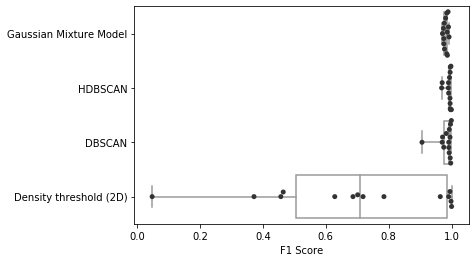

In [45]:
d = results[results['population'] == 'gdt']
ax = sns.boxplot(x="f1_score", y="method", data=d, whis=np.inf, color='white')
ax = sns.swarmplot(x="f1_score", y="method", data=d, color=".2")
ax.set_xlabel('F1 Score')
ax.set_ylabel('')

Text(0, 0.5, '')

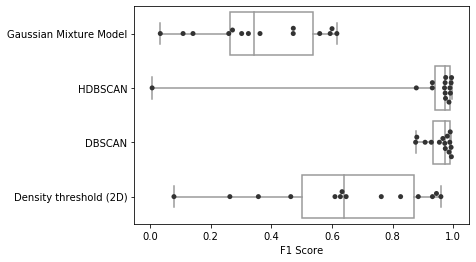

In [46]:
d = results[results['population'] == 'nongdt']
ax = sns.boxplot(x="f1_score", y="method", data=d, whis=np.inf, color='white')
ax = sns.swarmplot(x="f1_score", y="method", data=d, color=".2")
ax.set_xlabel('F1 Score')
ax.set_ylabel('')

Text(0, 0.5, '')

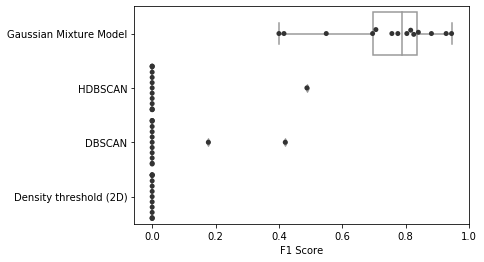

In [47]:
d = results[results['population'] == 'vd2Neg']
ax = sns.boxplot(x="f1_score", y="method", data=d, whis=np.inf, color='white')
ax = sns.swarmplot(x="f1_score", y="method", data=d, color=".2")
ax.set_xlabel('F1 Score')
ax.set_ylabel('')

In [37]:
hc = Gating(exp, 'hc4')

In [38]:
hc.populations.keys()

dict_keys(['root', 'cells', 'debris', 'lymphocytes', 'other_cells', 'manual_liveCD3', 'manual_liveCD3_Neg', 'gmm_liveCD3', 'gmm_liveCD3_NEG', 'dbscan_liveCD3', 'hdbscan_liveCD3', 'dens2d_liveCD3', 'dens2d_liveCD3_Neg', 'gmm_gdt', 'gmm_gdtNEG', 'gmm_nongdt', 'gmm_nongdtNEG', 'gmm_vd2Neg', 'gmm_vd2NegNEG', 'hdbscan_gdt', 'hdbscan_nongdt', 'hdbscan_vd2', 'dens2d_gdt', 'dens2d_nongdt', 'dens2d_vd2', 'dens2d_noise', 'dbscan_cells', 'dbscan_debris', 'dbscan_gdt', 'dbscan_nongdt', 'dbscan_vd2'])

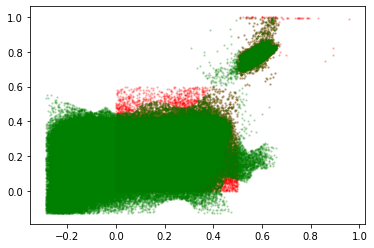

In [33]:
manual_gdt = apply_transform(hc.get_population_df('manual_gdt'), ['PanGD', 'Vd2'], 'logicle')
manual_nongdt = apply_transform(hc.get_population_df('manual_nongdt'), ['PanGD', 'Vd2'], 'logicle')
auto_gdt = apply_transform(hc.get_population_df('dbscan_gdt'), ['PanGD', 'Vd2'], 'logicle')
auto_nongdt = apply_transform(hc.get_population_df('dbscan_nongdt'), ['PanGD', 'Vd2'], 'logicle')

fig, ax = plt.subplots()
ax.scatter(manual_gdt['PanGD'], manual_gdt['Vd2'], s=2, alpha=0.2, c='red')
ax.scatter(manual_nongdt['PanGD'], manual_nongdt['Vd2'], s=2, alpha=0.2, c='red')
ax.scatter(auto_gdt['PanGD'], auto_gdt['Vd2'], s=2, alpha=0.2, c='green')
ax.scatter(auto_nongdt['PanGD'], auto_nongdt['Vd2'], s=2, alpha=0.2, c='green')
fig.show()